# Birds Classification CNN

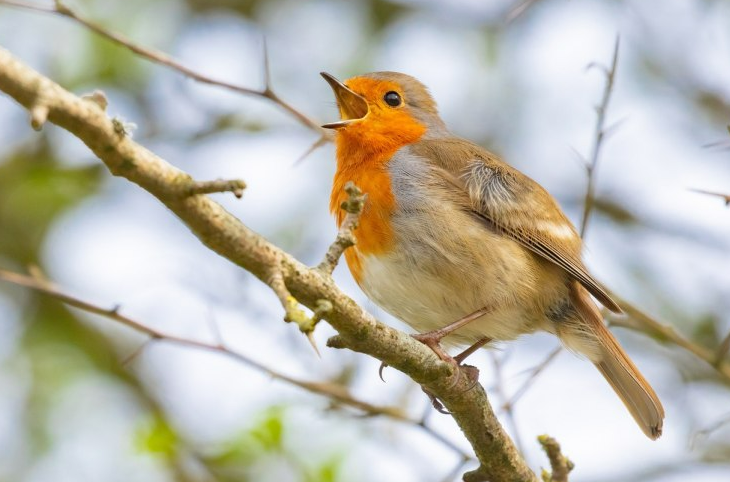

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import gc
import glob
import shutil
from pathlib import Path
from collections import defaultdict, Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from tqdm import tqdm
from PIL import Image
from IPython.display import clear_output

import random

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, StratifiedGroupKFold

import timm
import torch
from torchvision import models, transforms
import torch.optim as optim
import torchaudio
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts, CosineAnnealingLR, CyclicLR, ExponentialLR, OneCycleLR
from torchvision import models, transforms
from torch.nn import functional as F
from torch.nn.modules.loss import _WeightedLoss

import librosa
!pip install audiomentations -q
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift


def set_seed(seed=12345):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)   
set_seed()

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [2]:
path = '/kaggle/input/birdclef-2024'

df = pd.read_csv(os.path.join(path, 'train_metadata.csv'))
df.head(2)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg


In [3]:
class CFG:
    resize = 128
    batch_size_image = 32
    batch_size_audio = 128
    n_classes = len(df.primary_label.unique())
    transform  = transforms.Compose([transforms.Resize(resize), transforms.ToTensor()])
    aug = Compose([AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.3),
                   TimeStretch(min_rate=0.8, max_rate=1.2, p=0.3), PitchShift(min_semitones=-4, max_semitones=4, p=0.3)])
    num_classes = len(df.primary_label.unique())
    duration = 10
    sample_rate = 32000
    hidden_dim = 168

222

In [4]:
!mkdir images
!unzip -q -o /kaggle/input/birdclef-spectrogram-generator/_output_.zip -d images | awk 'BEGIN {ORS=" "} {if(NR%50==0)print "."}'

mkdir: cannot create directory ‘images’: File exists


In [5]:
!ls /kaggle/working/images/kaggle/working/train_images/

asbfly	 bncwoo3  compea   grbeat1  indpit1  lirplo   piekin1  rufwoo2	whbsho3
ashdro1  brakit1  comros   grecou1  indrob1  litegr   placuc3  rutfly6	whbtre1
ashpri1  brasta1  comsan   greegr   indrol2  litgre1  plaflo1  sbeowl1	whbwag1
ashwoo2  brcful1  comtai1  grefla1  indtit1  litspi1  plapri1  scamin3	whbwat1
asikoe2  brfowl1  copbar1  grehor1  ingori1  litswi1  plhpar1  shikra1	whbwoo2
asiope1  brnhao1  crbsun2  grejun2  inpher1  lobsun2  pomgrp2  smamin1	whcbar1
aspfly1  brnshr   cregos1  grenig1  insbab1  maghor2  purher1  sohmyn1	whiter2
aspswi1  brodro1  crfbar1  grewar3  insowl1  malpar1  pursun3  spepic1	whrmun
barfly1  brwjac1  crseag1  grnsan   integr   maltro1  pursun4  spodov	whtkin2
barswa	 brwowl1  dafbab1  grnwar1  isbduc1  malwoo1  purswa3  spoowl1	woosan
bcnher	 btbeat1  darter2  grtdro1  jerbus2  marsan   putbab1  sqtbul1	wynlau1
bkcbul1  bwfshr1  eaywag1  gryfra   junbab2  mawthr1  redspu1  stbkin1	yebbab1
bkrfla1  categr   emedov2  grynig2  junmyn1  moipig1  rers

##  SPECTROGRAMS

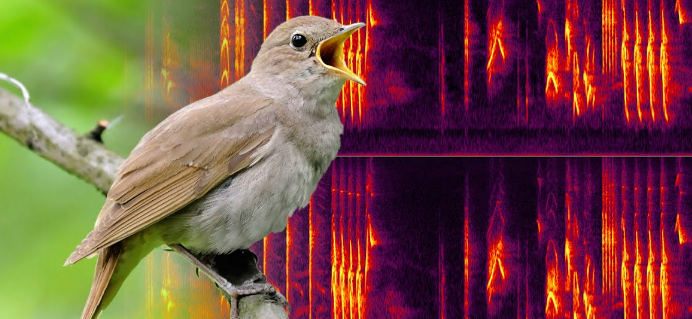

In [6]:
dir_ = Path('/kaggle/working/images/kaggle/working/train_images')
files = sorted(list(dir_.rglob('*.png')))

data = {'label':[], 'path_image':[]}
for file in files:
    data['label'].append(file.parent.name)
    data['path_image'].append(file)

annotations = pd.DataFrame(data)
annotations.head(2)

,label,path_image
0,asbfly,/kaggle/working/images/kaggle/working/train_im...
1,asbfly,/kaggle/working/images/kaggle/working/train_im...


In [34]:
class BirdSpectogramsDataset(Dataset):

    def __init__(self, files, labels, transform):
        self.files = files
        self.labels = labels
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)
        self.transform = transform
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, index):
        img = Image.open(self.files[index])
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        
        sample = {'image': img,'label': y}    
        sample['image'] = self.transform(sample['image'])
       
        return sample['image'], sample['label'], label

In [8]:
class_weights = Counter(annotations['label'].values)
class_weights = [annotations.shape[0]/class_weights[i] for i in sorted(annotations['label'].unique())]
class_weights = [val/sum(class_weights) for val in class_weights]

In [9]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345)

for fold, ( _, val_) in enumerate(skf.split(X=annotations, y=annotations.label)):
      annotations.loc[val_ , 'kfold'] = int(fold)

In [10]:
def imshow_(inp, title=None, plt_ax=plt, default=False):

    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp) 
    try: 
        if title is not None:
            plt_ax.set_title(title)
    except:
        plt.title(title)
    plt_ax.grid(False)

In [4]:
def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)

def collate_fn(batch):
    tensors, targets = [], []
    for sig, label, _ in batch:
        tensors += [sig]
        targets += [label]
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)
    return tensors, targets, _

def prepare_loaders(df, fold, column=None, aug=None):
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    if column=='path_image':
        train_dataset = BirdSpectogramsDataset(df_train[column].values, df_train.label.values, CFG.transform)
        valid_dataset = BirdSpectogramsDataset(df_valid[column].values, df_valid.label.values, CFG.transform)
        train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size_image, num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size_image, num_workers=2, shuffle=False, pin_memory=True)
    elif column=='path_audio':
        train_dataset = BirdsSongsDataset(df_train[column].values, df_train.label.values, aug=aug, sample_rate=CFG.sample_rate, duration=CFG.duration)
        valid_dataset = BirdsSongsDataset(df_valid[column].values, df_valid.label.values, aug=aug, sample_rate=CFG.sample_rate, duration=CFG.duration)
        train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size_audio, num_workers=4, shuffle=True, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size_audio, num_workers=4, shuffle=False, pin_memory=True, drop_last=True)
    else:
        train_dataset = BirdsSongsDatasetMEL(df_train['path_audio'].values, df_train.label.values, sample_rate=CFG.sample_rate, duration=CFG.duration)
        valid_dataset = BirdsSongsDatasetMEL(df_valid['path_audio'].values, df_valid.label.values, sample_rate=CFG.sample_rate, duration=CFG.duration)
        train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size_audio, num_workers=2, shuffle=True, pin_memory=True, drop_last=True)
        valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size_audio, num_workers=2, shuffle=False, pin_memory=True, drop_last=True)
      
    return train_dataset, valid_dataset, train_loader, valid_loader

In [46]:
train_dataset, valid_dataset, train_loader, valid_loader = prepare_loaders(annotations, 0, 'path_image')

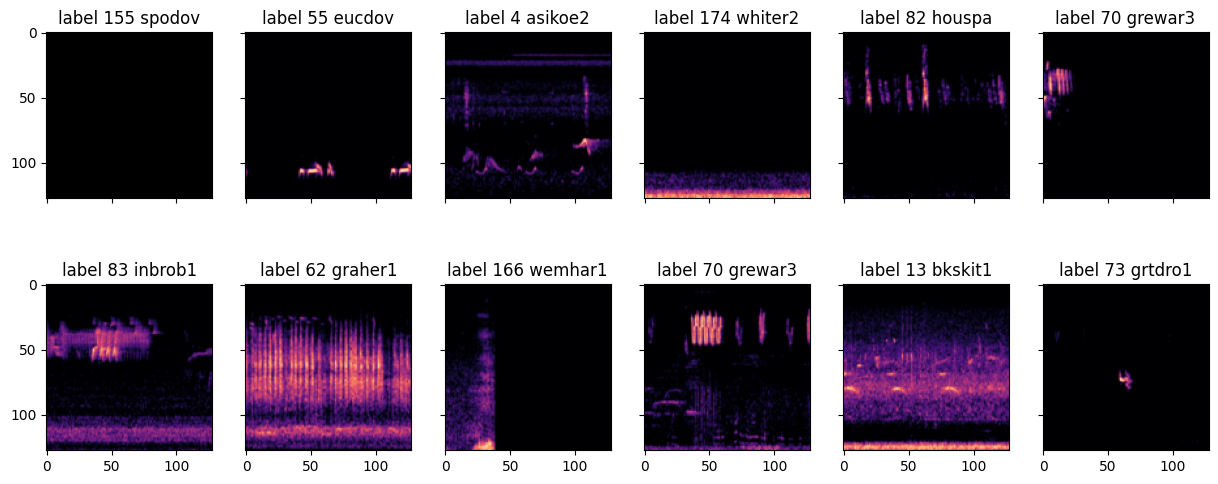

In [47]:
fig, ax = plt.subplots(nrows=2, ncols=6,figsize=(15, 6), sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,len(train_dataset)))
    im_val, label, name = train_dataset[random_characters]
    imshow_(im_val, title=f'label {label} {name}', plt_ax=fig_x)

In [48]:
class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super(GeM, self).__init__()
        self.p = nn.Parameter(torch.ones(1)*p)
        self.eps = eps

    def forward(self, x):
        return self.gem(x, p=self.p, eps=self.eps)
        
    def gem(self, x, p=3, eps=1e-6):
        return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1./p)

In [5]:
def show_result(data, best_score):
    plt.figure(figsize=(22, 7))
        
    plt.subplot(1, 2, 1)
    sns.lineplot(data=data, x='epoch', y='train_loss', color = 'darkcyan')
    sns.lineplot(data=data, x='epoch', y='valid_loss', color = 'cornflowerblue')
    plt.ylabel('loss')
    plt.legend(['train_loss', 'valid_loss'])
    plt.title('Loss values')

    plt.subplot(1, 2, 2)
    sns.lineplot(data=data, x='epoch', y='train_f1', color = 'darkcyan')
    sns.lineplot(data=data, x='epoch', y='valid_f1', color = 'cornflowerblue')
    sns.lineplot(data=data, x='epoch', y=0.5, style=True, dashes=[(3,3)], color = 'tan')
    mask = np.array(data['valid_f1'])==best_score
    plt.scatter(np.array(data['epoch'])[mask], np.array(data['valid_f1'])[mask], color='salmon', s=40, marker='^')
    plt.ylabel('score')
    plt.legend(['train_f1', 'valid_f1', 'threshold'])
    plt.title('Score: f1')
        
    plt.show()   

In [6]:
def train(model, optimizer, loss_fn, epochs, loaders, type_file=None, scheduler=None):
    
    best_score = 0
    for epoch in range(1, epochs+1):
        model.train()
        scaler =  torch.cuda.amp.GradScaler() 
        result['epoch'].append(epoch)
        for mode, dataloader in tqdm(loaders.items()):
            running_loss, f1_, processed_data, valid_loss = 0,[],0, 0
            
            for X_batch, Y_batch, _ in dataloader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device, dtype=torch.long)

                if mode =='train':
                    model.train()
                    optimizer.zero_grad() 
                    Y_pred = model(X_batch)
                else: 
                    model.eval()  
                    with torch.no_grad(): 
                        Y_pred = model(X_batch)
                
                if type_file=='audio':
                    loss = loss_fn(Y_pred.squeeze(), Y_batch)
                    preds = torch.argmax(Y_pred, dim=-1)
                else:
                    loss = loss_fn(Y_pred, Y_batch)
                    preds = torch.argmax(Y_pred, dim=1)
                
                running_loss += loss.item() * X_batch.size(0)
                processed_data += X_batch.size(0)
                
                f1_.append(f1_score(Y_batch.detach().cpu().numpy(), preds.detach().cpu().numpy(), average='macro'))
                
                if mode =='train':
                    scaler.scale(loss).backward() #retain_graph=True
                    scaler.step(optimizer)
                    scaler.update()

            loss_score = running_loss/processed_data
            f1 = np.mean(f1_)
            result[str(mode)+'_loss'].append(loss_score)
            result[str(mode)+'_f1'].append(f1)
            
            if mode =='valid':
                if f1 > best_score:
                    best_score = f1
                    torch.save(model.state_dict(), f'weights.bin')   
            lr = optimizer.param_groups[0]['lr']
            if scheduler is not None:
                scheduler.step()
            
        clear_output(wait=True)
        print(f'epoch training: {epoch}, lr optimizer: {lr}, loss value validate:{loss_score:10.4f}, f1 validate:{f1:10.4f}') #
        print()

        show_result(result, best_score)
        
        torch.cuda.empty_cache()
        gc.collect()

In [55]:
class BirdSpectogramsModel(nn.Module):
    def __init__(self, num_classes, pretrained=True, checkpoint_path=None):
        super(BirdSpectogramsModel, self).__init__()
        self.model = timm.create_model('tf_efficientnetv2_s_in21ft1k', pretrained=True,
                                       pretrained_cfg_overlay=dict(file='/kaggle/input/tf-efficientnetv2-l-s/tf_efficientnetv2_s_21ft1k-d7dafa41.pth'))
        in_features = self.model.classifier.in_features
        self.model.classifier = nn.Identity()
        self.model.global_pool = nn.Identity()
        self.pooling = GeM()
        self.linear = nn.Linear(in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, images):
        features = self.model(images)
        pooled_features = self.pooling(features).flatten(1)
        output = self.linear(pooled_features)
        return output

In [56]:
model = BirdSpectogramsModel(CFG.num_classes)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)
criterion = nn.CrossEntropyLoss(torch.FloatTensor(class_weights).to(device)) 

loaders = {'train': train_loader, 'valid': valid_loader}

epoch training: 10, lr optimizer: 0.0001, loss value validate:    1.1818, f1 validate:    0.8625



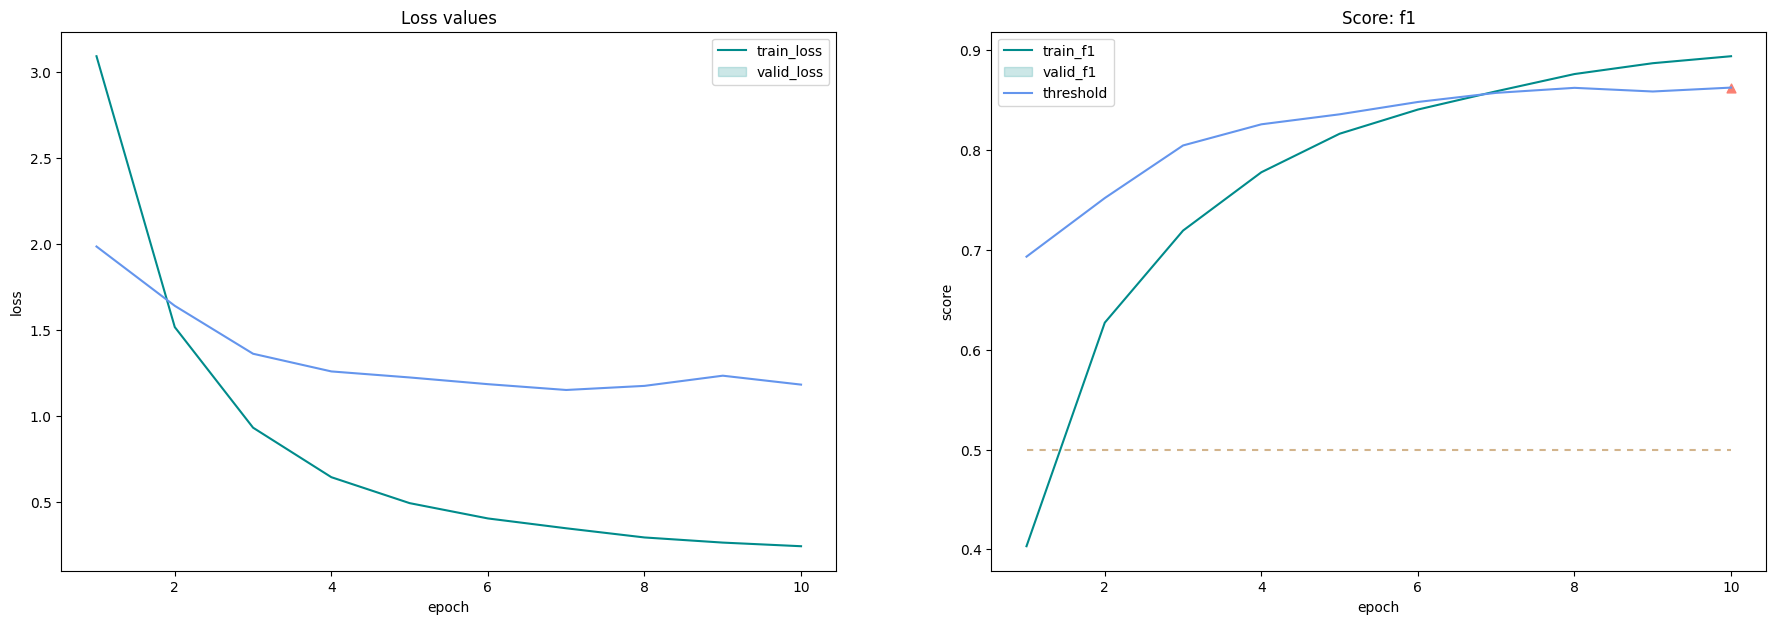

In [ ]:
result = {
    'epoch':[],'train_loss':[],'valid_loss':[],'train_f1':[],'valid_f1':[]
}
epochs = 10
train(model.to(device), optimizer, criterion, epochs, loaders) 

## RESUME
___________________________________

Отлично. Классификация по изображениям спектограмм дала хорошие результаты, которые можно еще более улучшить тюнингом гиперпараметров, скорости обучения и за счет использования изображений более высокого качества (досточно будет 256х256).

Ниже представлены неудавшиеся исследования:
 - **Обучение по аудиозаписям с использованием CNN**
 - **Обучение по аудиозаписям трансформированным в MelSpectrogram + MFCC с использованием LSTM**
 
Данные эксперименты не показали хороших результатов и приводятся только с целью ознакомления. В качестве гипотезы можно предположить, что причиной этому послужила прерывистость аудиозаписей (крики это не песня - они повторяются через промежутки времени, в паузах между которыми присутсвует лишний шум). Недостаточность данных повлияло на обучение - как видно из графиков, модели просто заучивают ответы, не улавливая связей и зависимостей. Различный перебор архитектур моделей и гиперпараметров не дал ощутимого прироста в качестве.


## AUDIOFILES CNN <font color='red'>(unsuccessful)</font>

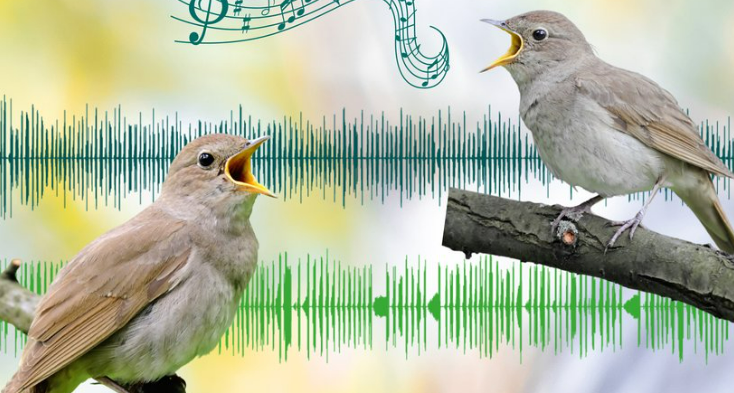

In [7]:
dir_ = Path('/kaggle/input/birdclef-2024/train_audio')
files = sorted(list(dir_.rglob('*.ogg')))

data = {'label':[], 'path_audio':[]}
for file in files:
    data['label'].append(file.parent.name)
    data['path_audio'].append(file)

annotations = pd.DataFrame(data)
annotations.head(2)

,label,path_audio
0,asbfly,/kaggle/input/birdclef-2024/train_audio/asbfly...
1,asbfly,/kaggle/input/birdclef-2024/train_audio/asbfly...


In [8]:
class BirdsSongsDataset(Dataset):
    def __init__(self, files, labels, aug=None, sample_rate=32000, duration=5):
        self.files = files
        self.labels = labels
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)
        self.aug = aug
        self.sample_rate = sample_rate
        self.num_samples = 16000 #sample_rate*duration

    def __len__(self):
        return len(self.files)
    
    def normalize_audio(self, audio):
        audio = np.array(audio).astype('float32')
        normalized_audio = audio/np.max(np.abs(audio))
        normalized_audio = np.nan_to_num(normalized_audio)
        return normalized_audio # Нормализация аудиозаписи по максимальному значению амплитуды
   

    def __getitem__(self, index):
        audio_path = self.files[index]
        sig, sr = torchaudio.load(audio_path)
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            sig = resampler(sig)
        sig = torch.mean(sig, dim=0, keepdim=True)
        mask = torch.zeros([1, self.num_samples]) 
        if sig.numel() < self.num_samples:
            mask[:, :sig.numel()] = sig
        else:
            mask = sig[:, :self.num_samples]
        sig = mask
        
        sig = self.normalize_audio(sig)
        if self.aug is not None:
            sig = self.aug(samples=sig, sample_rate=sr)

        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        sample = {'audio': torch.tensor(sig),'label': torch.tensor(y)}  
       
        return sample['audio'], sample['label'], label

In [9]:
class BirdSongsModel(nn.Module):
    def __init__(self, num_classes, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(1, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = F.leaky_relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.leaky_relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.leaky_relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.leaky_relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return x #F.log_softmax(x) 

In [10]:
class_weights = Counter(annotations['label'].values)
class_weights = [annotations.shape[0]/class_weights[i] for i in sorted(annotations['label'].unique())]
class_weights = [val/sum(class_weights) for val in class_weights]

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=12345)

for fold, ( _, val_) in enumerate(skf.split(X=annotations, y=annotations.label)):
      annotations.loc[val_ , 'kfold'] = int(fold)

In [11]:
train_dataset, valid_dataset, train_loader, valid_loader = prepare_loaders(annotations, 0, 'path_audio', aug = CFG.aug)
loaders = {'train': train_loader, 'valid': valid_loader}

In [ ]:
class SmoothCrossEntropyLoss(_WeightedLoss):
    def __init__(self, weight=None, reduction='mean', smoothing=1e-8):
        super().__init__(weight=weight, reduction=reduction)
        self.smoothing = smoothing
        self.weight = weight
        self.reduction = reduction

    def k_one_hot(self, targets:torch.Tensor, n_classes:int, smoothing=0):
        with torch.no_grad():
            targets = torch.empty(size=(targets.size(0), n_classes), device=targets.device) \
                                  .fill_(smoothing /(n_classes-1)) \
                                  .scatter_(1, targets.data.unsqueeze(1), 1.-smoothing)
        return targets

    def reduce_loss(self, loss):
        return loss.mean() if self.reduction == 'mean' else loss.sum() if self.reduction == 'sum' else loss

    def forward(self, inputs, targets):
        assert 0 <= self.smoothing < 1
        targets = self.k_one_hot(targets, inputs.size(-1), self.smoothing)
        log_preds = F.log_softmax(inputs, -1)
        if self.weight is not None:
            log_preds = log_preds * self.weight.unsqueeze(0)
        return self.reduce_loss(-(targets * log_preds).sum(dim=-1))

In [12]:
model = BirdSongsModel(CFG.num_classes)
model.to(device)

#criterion = SmoothCrossEntropyLoss() 
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
criterion = nn.CrossEntropyLoss(torch.FloatTensor(class_weights).to(device)) 

epoch training: 6, lr optimizer: 0.01, loss value validate:    5.7166, f1 validate:    0.0031



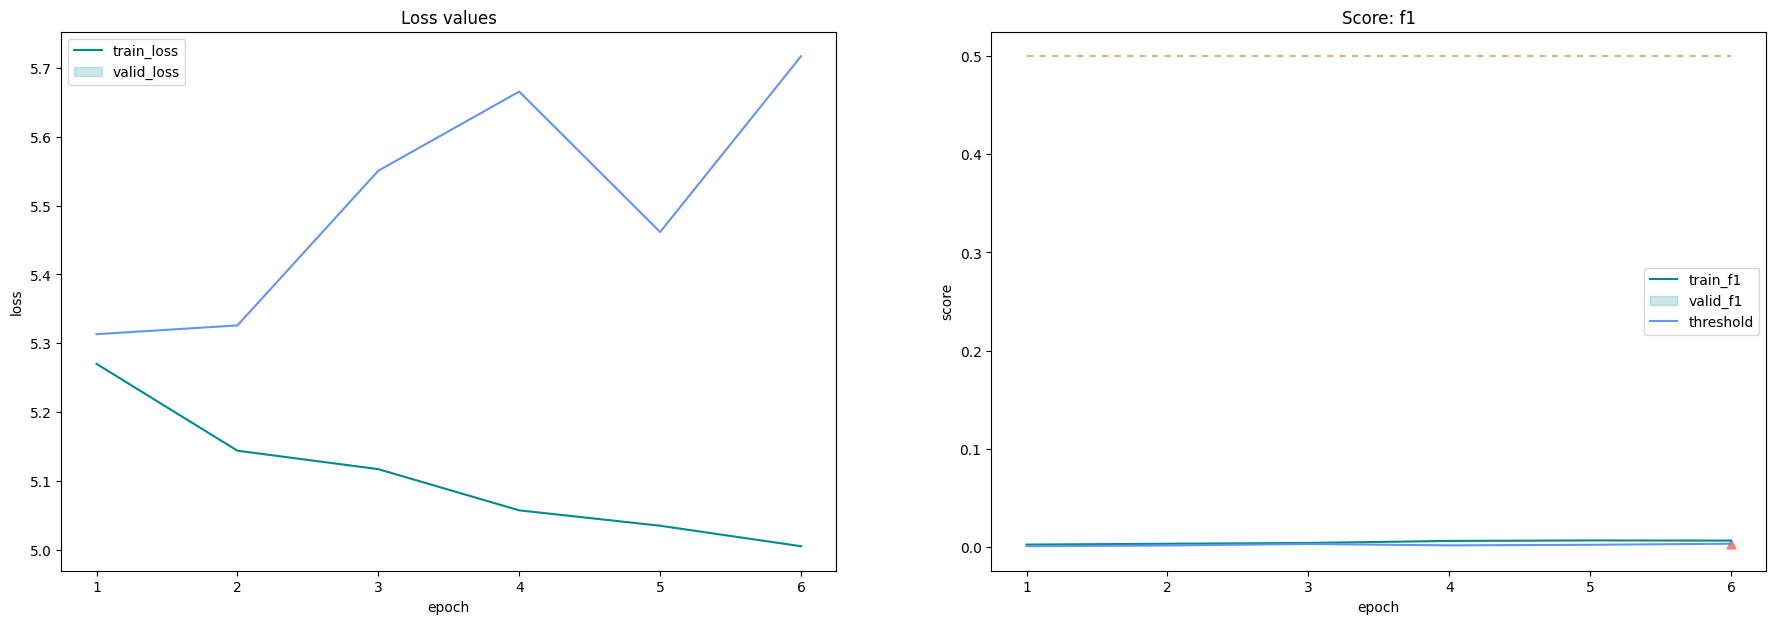

In [13]:
result = {
    'epoch':[],'train_loss':[],'valid_loss':[],'train_f1':[],'valid_f1':[]
}
epochs = 6
train(model.to(device), optimizer, criterion, epochs, loaders, type_file='audio') 

## AUDIOFILES LSTM <font color='red'>(unsuccessful)</font>

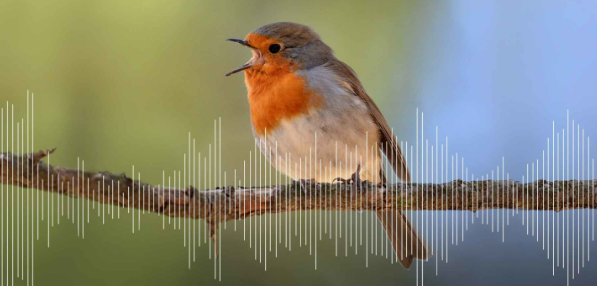

In [14]:
class BirdsSongsDatasetMEL(Dataset):
    def __init__(self, files, labels, sample_rate=32000, duration=5):
        self.files = files
        self.labels = labels
        self.label_encoder = LabelEncoder()
        self.label_encoder.fit(self.labels)
        self.sample_rate = sample_rate
        self.num_samples = 16000#sample_rate*duration

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        audio_path = self.files[index]
        sig, sr = torchaudio.load(audio_path)
        if sr != self.sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.sample_rate)
            sig = resampler(sig)
        sig = torch.mean(sig, dim=0, keepdim=True)
        mask = torch.zeros([1, self.num_samples]) 
        if sig.numel() < self.num_samples:
            mask[:, :sig.numel()] = sig
        else:
            mask = sig[:, :self.num_samples]
        sig = mask

        mel_specgram = torchaudio.transforms.MelSpectrogram(sample_rate = self.sample_rate)(sig)  # (channel, n_mels, time)
        mel_specgram_norm = (mel_specgram - mel_specgram.mean()) / mel_specgram.std()
        mfcc = torchaudio.transforms.MFCC(sample_rate = self.sample_rate)(sig)  # (channel, n_mfcc, time)
        mfcc_norm = (mfcc - mfcc.mean()) / mfcc.std()
        feature = torch.cat([mel_specgram, mfcc], axis=1)
    
        label = self.labels[index]
        label_id = self.label_encoder.transform([label])
        y = label_id.item()
        sample = {'audio': feature[0].permute(1, 0),'label': torch.tensor(y)} 
       
        return sample['audio'], sample['label'], label

In [15]:
class BirdLSTMModel(nn.Module):

    def __init__(self, hidden_dim, num_classes, batch_size, n_hidden=256, n_layers=2, drop_prob=0.3):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.n_feature = hidden_dim
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.n_feature, self.n_hidden, self.n_layers, dropout=self.drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc1 = nn.Linear(n_hidden, int(n_hidden/2))
        self.fc2 = nn.Linear(int(n_hidden/2), num_classes)   

    def forward(self, x):    
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, self.batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, self.batch_size, self.n_hidden).zero_().cuda())
        x, _ = self.lstm(x, hidden) # x.shape (batch, seq_len, n_features)
        x = self.dropout(x) # out.shape (batch, seq_len, n_hidden*direction)
        x = F.relu(self.fc1(x))
        x = self.fc2(x[:, -1, :]) #F.log_softmax(self.fc2(x[:, -1, :]))  out.shape (batch, out_feature)
        return x

In [16]:
train_dataset, valid_dataset, train_loader, valid_loader = prepare_loaders(annotations, 0)
loaders = {'train': train_loader, 'valid': valid_loader}

In [17]:
model = BirdLSTMModel(CFG.hidden_dim, CFG.num_classes, batch_size=CFG.batch_size_audio)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=2)
criterion = nn.CrossEntropyLoss(torch.FloatTensor(class_weights).to(device)) 

loaders = {'train': train_loader, 'valid': valid_loader}

epoch training: 6, lr optimizer: 0.01, loss value validate:    5.2390, f1 validate:    0.0057



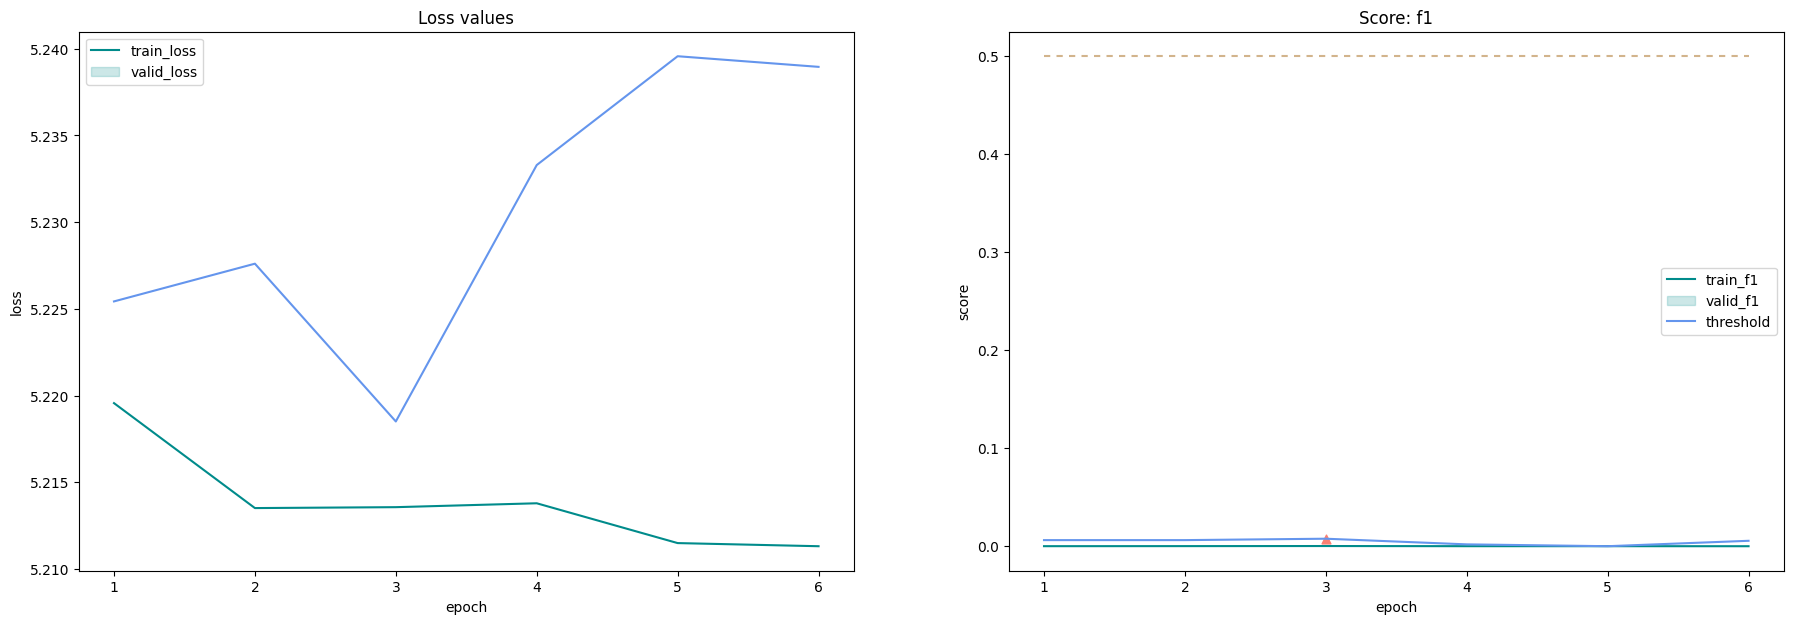

In [ ]:
result = {
    'epoch':[],'train_loss':[],'valid_loss':[],'train_f1':[],'valid_f1':[]
}
epochs = 6
train(model.to(device), optimizer, criterion, epochs, loaders, scheduler) 